In [1]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy import stats
from sklearn.metrics import accuracy_score
import csv
from sklearn.metrics import confusion_matrix

import extract_correct_csv
import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 31415
rng = default_rng(RANDOM_SEED)

# all valid subjects
all_subject = extract_correct_csv.extract_only_valid_subject()

all_subject.remove(2)
all_subject.remove(4)
all_subject.remove(49)

# all k = {2, 4, 6, 8} for the latent space
valid_k_list = list(range(2, 10))

# keep only generalization trials
num_trials_to_remove = 48


# functions that creates triangular matrices
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="aesara"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"aesara", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "aesara":
            return at.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = at.zeros((d, k), dtype=float) if mtype == "aesara" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out


def makeW(d, k, dim_names, name):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z_" + name, 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b_" + name, 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, at.ones(k))
    W = pm.Deterministic(name, at.dot(L, at.diag(at.extra_ops.cumsum(z))), dims=dim_names)
    return W


'''columns = ['subject', 'k', 'train', 'val', 'test']
with open('FAFake.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(columns)
'''
all_subject = [2]
valid_k_list = [3]

sub= 2
k= 3# eda data
eda = pd.read_csv('data_fake/features_4_2/eda/' + str(sub) + '.csv')
eda = eda[num_trials_to_remove:]

# hr data
hr = pd.read_csv('data_fake/features_4_2/hr/' + str(sub) + '.csv')
hr = hr[num_trials_to_remove:]

# pupil data
# pupil = pd.read_csv('data/features_4_2/pupil/' + str(sub) + '.csv')
# pupil = pupil[num_trials_to_remove:]

# pain expectation data
string_sub = extract_correct_csv.read_correct_subject_csv(sub)
df_ = pd.read_csv('data/LookAtMe_0' + string_sub + '.csv', sep='\t')
df_ = df_[num_trials_to_remove:]
label = np.array(list([int(d > 2) for d in df_['rating']]))
E = label[:, np.newaxis]
E = pd.DataFrame(E)

# num trials
N = eda.shape[0]

TRAIN_PERC = 0.70
VAL_PERC = 0.1
TEST_PERC = 0.2  # 1-TRAIN_PERC+VAL_PERC
N_train = int(N * (TRAIN_PERC))
N_val = int(N * (VAL_PERC))

# RANDOM SPLIT
# pupil = pupil.sample(frac=1, random_state=0)
# pupil = pupil.reset_index(drop=True).to_numpy()

hr = hr.sample(frac=1, random_state=0)
hr = hr.reset_index(drop=True).to_numpy()

eda = eda.sample(frac=1, random_state=0)
eda = eda.reset_index(drop=True).to_numpy()

e_labels = E.sample(frac=1, random_state=0)
e_labels = e_labels.reset_index(drop=True).to_numpy()

hr_train = hr[:N_train]
eda_train = eda[:N_train]
# pupil_train = pupil[:N_train]
e_labels_train = e_labels[:N_train]

hr_val = hr[N_train:N_train + N_val]
eda_val = eda[N_train:N_train + N_val]
# pupil_val = pupil[N_train:N_train + N_val]
e_labels_val = e_labels[N_train:N_train + N_val]

hr_test = hr[N_train + N_val:]
eda_test = eda[N_train + N_val:]
# pupil_test = pupil[N_train + N_val:]
e_labels_test = e_labels[N_train + N_val:]

# dimensions of each signal
d_eda = eda_train.shape[1]
d_hr = hr_train.shape[1]
# d_pupil = pupil_train.shape[1]
d_e = e_labels_train.shape[1]

# print(d_eda, d_hr, d_pupil, d_e)
# print(hr_train.shape)
# print(hr_val.shape)
# print(hr_test.shape)
# print(eda_train.shape)
# print(eda_val.shape)
# print(eda_test.shape)
# print(pupil_train.shape)
# print(pupil_val.shape)
# print(pupil_test.shape)
# print(e_labels_train.T.shape)
# print(e_labels_val.shape)
# print(e_labels_test.shape)

# model definition
with pm.Model() as PPCA_identified:
    # model coordinates
    PPCA_identified.add_coord("latent_columns", np.arange(k), mutable=True)
    PPCA_identified.add_coord("rows", np.arange(N_train), mutable=True)
    PPCA_identified.add_coord("observed_eda", np.arange(d_eda), mutable=False)
    PPCA_identified.add_coord("observed_hr", np.arange(d_hr), mutable=False)
    # PPCA_identified.add_coord("observed_pupil", np.arange(d_pupil), mutable=False)
    PPCA_identified.add_coord("observed_label", np.arange(d_e), mutable=False)

    hr_data = pm.MutableData("hr_data", hr_train.T, dims=["observed_hr", "rows"])
    eda_data = pm.MutableData("eda_data", eda_train.T, dims=("observed_eda", "rows"))
    # pupil_data = pm.MutableData("pupil_data", pupil_train.T, dims=("observed_pupil", "rows"))

    W_eda = makeW(d_eda, k, ("observed_eda", "latent_columns"), 'W_eda')
    W_hr = makeW(d_hr, k, ("observed_hr", "latent_columns"), 'W_hr')
    # W_pupil = makeW(d_pupil, k, ("observed_pupil", "latent_columns"), 'W_pupil')

    W_e = pm.Normal("W_e", dims=["observed_label", "latent_columns"])
    C = pm.Normal("C", dims=["latent_columns", "rows"])

    psi_eda = pm.HalfNormal("psi_eda", 1.0)
    X_eda = pm.Normal("X_eda", mu=at.dot(W_eda, C), sigma=psi_eda, observed=eda_data,
                      dims=["observed_eda", "rows"])

    psi_hr = pm.HalfNormal("psi_hr", 1.0)
    X_hr = pm.Normal("X_hr", mu=at.dot(W_hr, C), sigma=psi_hr, observed=hr_data, dims=["observed_hr", "rows"])

    # psi_pupil = pm.HalfNormal("psi_pupil", 1.0)
    # X_pupil = pm.Normal("X_pupil", mu=at.dot(W_pupil, C), sigma=psi_pupil, observed=pupil_data,dims=["observed_pupil", "rows"])

    X_e = pm.Bernoulli("X_e", p=pm.math.sigmoid(at.dot(W_e, C)), dims=["observed_label", "rows"],
                       observed=e_labels_train.T)

In [3]:
gv = pm.model_to_graphviz(PPCA_identified)
gv.view('PPCA factor')

'PPCA factor.pdf'

In [4]:
with PPCA_identified:
    approx = pm.fit(80000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(1000)

qt5ct: using qt5ct plugin
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/32/"
Invalid Context= "Apps" line

Finished [100%]: Average Loss = 28,760


In [10]:
c_ = trace.posterior['C'][0].to_numpy().mean(axis=0)
whr_ = trace.posterior['W_hr'][0].to_numpy().mean(axis=0)
we_ = trace.posterior['W_e'][0].to_numpy().mean(axis=0)

O = np.dot(we_,c_)
generated= np.matmul(np.linalg.pinv(we_), O)
np.allclose(c_,generated)

False

In [19]:
e_pred_mode_train.T

array([[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]])

In [21]:
np.where(O<0,0,1)

array([[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]])

In [22]:
accuracy_score(e_pred_mode_train.T,np.where(O<0,0,1))

1.0

In [5]:
with PPCA_identified:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["X_e"], random_seed=123)

e_pred_train = posterior_predictive.posterior_predictive['X_e']
e_pred_mode_train = np.squeeze(stats.mode(e_pred_train[0], keepdims=False)[0])[:, np.newaxis]

Sampling: [X_e]


In [6]:
train_accuracy_exp = accuracy_score(e_labels_train, e_pred_mode_train)

In [7]:
train_accuracy_exp

1.0

<Figure size 640x480 with 0 Axes>

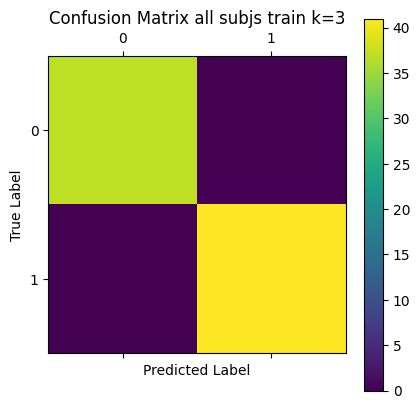

In [8]:
conf_mat_train = confusion_matrix(e_labels_train, e_pred_mode_train)
fig = plt.figure()
plt.matshow(conf_mat_train)
plt.title('Confusion Matrix all subjs train k=' + str(k))
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [11]:
C_val = np.matmul(np.linalg.pinv(whr_),hr_val.T)
C_val

array([[ 6.04765323,  6.93756238,  7.40360641,  6.34486071,  5.92045809,
         4.40603195,  6.32835489,  7.10918201,  7.70090362,  5.68404554,
         6.39385694],
       [-2.48180186, -3.61159021, -3.96584743, -3.38372878, -4.43679122,
        -1.37412961, -2.36878532, -5.43171615, -4.18235441, -2.06580558,
        -2.26645921],
       [ 1.55860794,  1.59240011,  1.83561879,  1.45295167,  3.18292065,
         2.55926982,  1.65144231,  2.96993423,  1.88635843,  1.48162594,
         1.63881343]])

In [12]:
val_label_gen = np.dot(we_,C_val)

In [13]:
np.where(val_label_gen<0,0,1)

array([[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]])

In [14]:
e_labels_val.T

array([[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]])

In [27]:
with PPCA_identified:
    # update values of predictors with validation:
    PPCA_identified.set_data(name="hr_data", values=hr_val.T, coords={'rows': range(hr_val.shape[0])})
    PPCA_identified.set_data("eda_data", eda_val.T, coords={'rows': range(eda_val.shape[0])})
    # PPCA_identified.set_data("pupil_data", pupil_val.T, coords={'rows': range(pupil_val.shape[0])})
    # use the updated values and predict outcomes and probabilities:

In [28]:
gv = pm.model_to_graphviz(PPCA_identified)
gv.view('PPCA factor')

'PPCA factor.pdf'

In [29]:
with PPCA_identified:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["X_e"], random_seed=123, predictions=True)

/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aesara/tensor/rewriting/shape.py:169: UserWarning: Failed to infer_shape from Op Elemwise{Sigmoid}[(0, 0)].
Input shapes: [(TensorConstant{1}, rows)]
Exception encountered during infer_shape: <class 'Exception'>
Exception message: sharedvar.value does not exist anymore. Use sharedvar.get_value() or sharedvar.set_value() instead.
Traceback: Traceback (most recent call last):
  File "/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aesara/tensor/rewriting/shape.py", line 145, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aesara/tensor/elemwise.py", line 834, in infer_shape
    out_shape = aesara.tensor.broadcast_shape(*i_shapes, arrays_are_shapes=True)
  File "/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/aesara/tensor/extra_ops.py", lin

In [44]:
posterior_predictive

Inference data with groups:
	> predictions
	> predictions_constant_data

In [30]:
e_pred = posterior_predictive.predictions['X_e']
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:, np.newaxis]

validation_accuracy_exp = accuracy_score(e_labels_val, e_pred_mode)

In [33]:
validation_accuracy_exp

0.45454545454545453

/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot: title={'center': 'W_e'}>,
        <AxesSubplot: title={'center': 'W_e'}>],
       [<AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'C'}>],
       [<AxesSubplot: title={'center': 'W_z_W_eda'}>,
        <AxesSubplot: title={'center': 'W_z_W_eda'}>],
       [<AxesSubplot: title={'center': 'W_b_W_eda'}>,
        <AxesSubplot: title={'center': 'W_b_W_eda'}>],
       [<AxesSubplot: title={'center': 'W_z_W_hr'}>,
        <AxesSubplot: title={'center': 'W_z_W_hr'}>],
       [<AxesSubplot: title={'center': 'W_b_W_hr'}>,
        <AxesSubplot: title={'center': 'W_b_W_hr'}>],
       [<AxesSubplot: title={'center': 'psi_eda'}>,
        <AxesSubplot: title={'center': 'psi_eda'}>],
       [<AxesSubplot: title={'center': 'psi_hr'}>,
        <AxesSubplot: title={'center': 'psi_hr'}>],
       [<AxesSubplot: title={'center': 'W_eda'}>,
        <AxesSubplot: title={'center': 'W_eda'}>],
       [<AxesSubplot: title={'center': 'W_hr'}>,
        <AxesSubplot

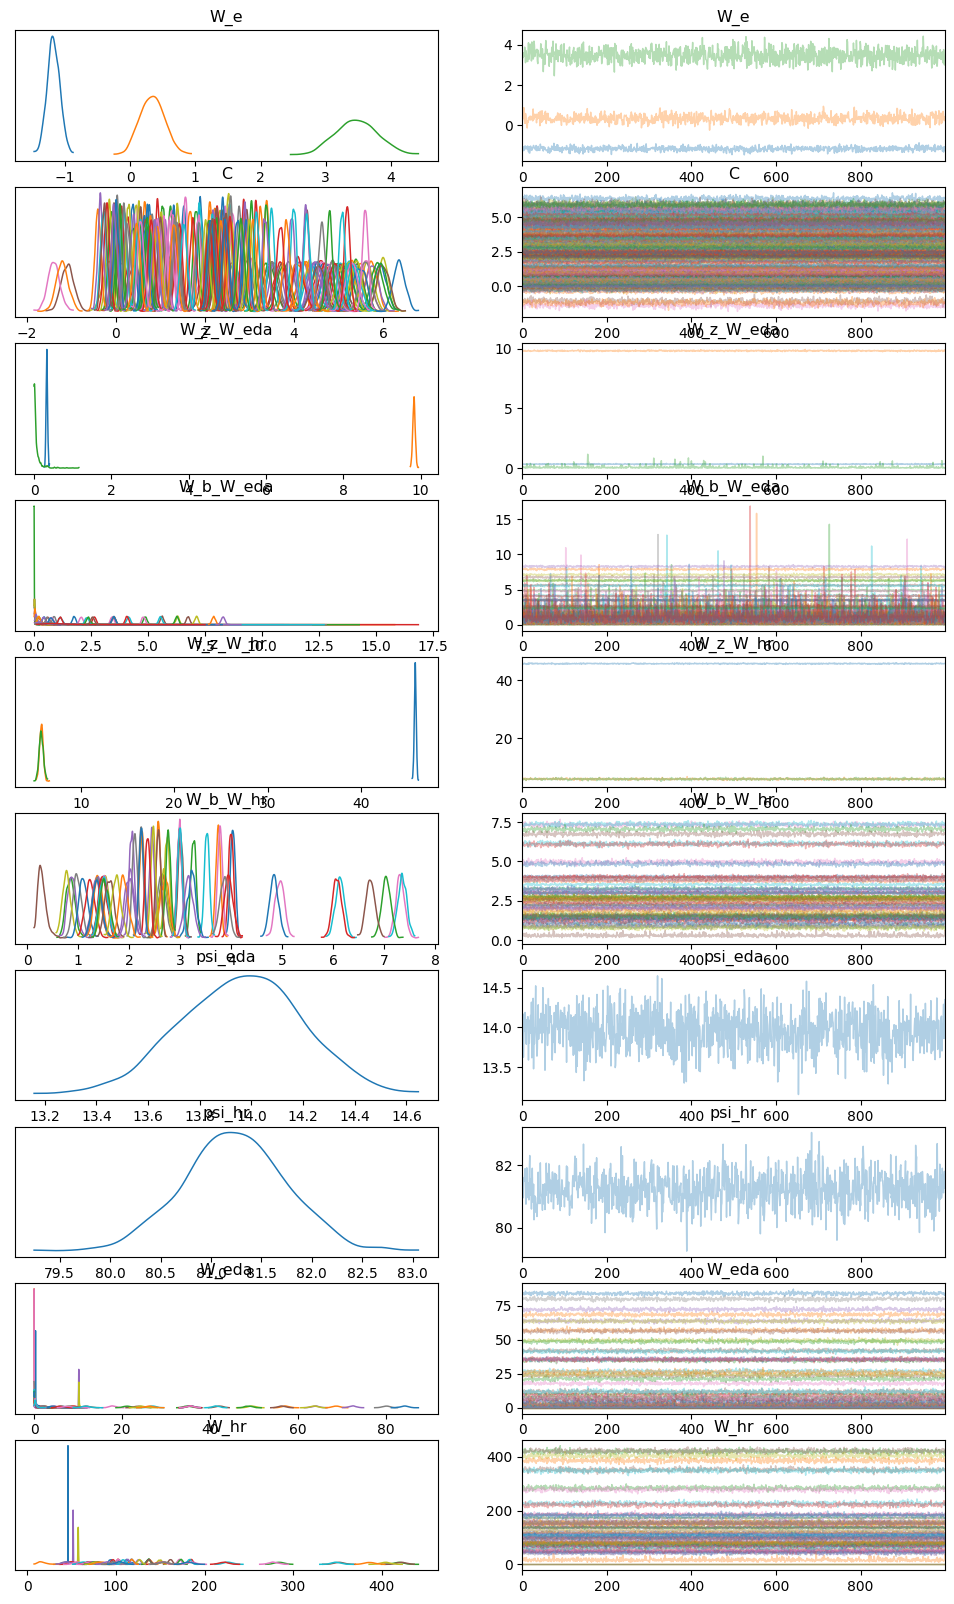

In [46]:
az.plot_trace(trace)

In [43]:
trace.posterior['C'][0]

<xarray.DataArray 'C' (draw: 1000, latent_columns: 3, rows: 78)>
array([[[ 4.59749288,  4.95462031,  3.51713002, ...,  4.75604414,
          5.32360954,  1.02767889],
        [ 2.31093369,  0.29447509,  1.91430203, ...,  3.08637051,
         -0.03777917, -0.24528458],
        [ 0.72439189,  0.81575538,  2.06641876, ...,  0.62329292,
          2.74691694,  3.55062858]],

       [[ 4.67256229,  5.13806927,  3.43197259, ...,  4.42400123,
          5.33531375,  1.30318078],
        [ 2.28132035,  0.17317185,  1.90817084, ...,  3.20338908,
         -0.0405667 , -0.0757334 ],
        [ 0.71151144,  0.86231343,  1.9247893 , ...,  0.39441628,
          2.81892473,  3.71466866]],

       [[ 4.68488822,  4.94661483,  3.22379065, ...,  4.582462  ,
          5.21466449,  1.38829352],
        [ 2.25258098,  0.25959719,  1.88555701, ...,  3.06062689,
         -0.12307217, -0.24234293],
        [ 0.78072814,  0.87222917,  2.17823861, ...,  0.59921757,
          2.81320832,  3.78787312]],
...
       [[ 4.71056213,  5.00560303,  3.34856986, ...,  4.32042746,
          5.41287186,  1.30272512],
        [ 2.34754953,  0.28397547,  1.95325043, ...,  3.08666053,
          0.06699714, -0.24147853],
        [ 0.58740324,  0.90438378,  1.99464424, ...,  0.4996934 ,
          2.83848179,  3.71444402]],

       [[ 4.26041774,  5.14777554,  3.31291087, ...,  4.63686434,
          5.10294954,  1.23993522],
        [ 2.3171458 ,  0.28291062,  1.96299831, ...,  3.12450455,
          0.06827133, -0.19865169],
        [ 0.75233409,  0.96147775,  2.14100102, ...,  0.4708207 ,
          2.73837858,  3.74923106]],

       [[ 4.62331991,  5.29962047,  3.32269741, ...,  4.54701069,
          5.1717094 ,  1.24583957],
        [ 2.3934416 ,  0.08534278,  1.84252019, ...,  3.306646  ,
         -0.1001825 , -0.22925377],
        [ 0.79354021,  0.85444884,  2.14002799, ...,  0.38822308,
          2.83057503,  3.80284061]]])
Coordinates:
    chain           int64 0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * latent_columns  (latent_columns) int64 0 1 2
  * rows            (rows) int64 0 1 2 3 4 5 6 7 8 ... 70 71 72 73 74 75 76 77

In [40]:
c_ = trace.posterior['C'][0].to_numpy().mean(axis=0)
whr_ = trace.posterior['W_hr'][0].to_numpy().mean(axis=0)
we_ = trace.posterior['W_e'][0].to_numpy().mean(axis=0)

O = np.dot(we_,c_)
generated= np.matmul(np.linalg.pinv(we_), O)
np.allclose(c_,generated)

False

In [42]:
np.where(O<0,0,1)

array([[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]])

<Figure size 640x480 with 0 Axes>

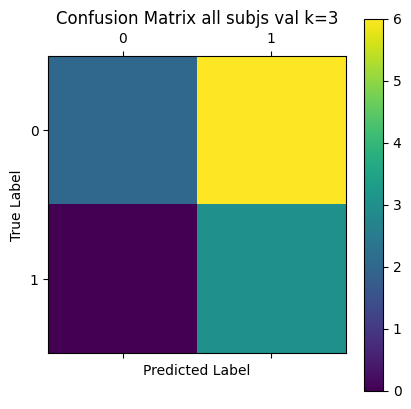

In [32]:
conf_mat_val = confusion_matrix(e_labels_val, e_pred_mode)
fig = plt.figure()
plt.matshow(conf_mat_val)
plt.title('Confusion Matrix all subjs val k=' + str(k))
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [36]:
e_pred_mode_train.T

array([[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]])

In [37]:
e_pred_mode.T

array([[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]])

In [38]:
e_pred_train

<xarray.DataArray 'X_e' (chain: 1, draw: 1000, observed_label: 1, rows: 78)>
array([[[[0, 0, 1, ..., 0, 1, 1]],

        [[0, 0, 1, ..., 0, 1, 1]],

        [[0, 0, 1, ..., 0, 1, 1]],

        ...,

        [[0, 1, 1, ..., 1, 1, 1]],

        [[0, 0, 1, ..., 0, 0, 1]],

        [[0, 0, 1, ..., 0, 1, 1]]]])
Coordinates:
  * chain           (chain) int64 0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * observed_label  (observed_label) int64 0
  * rows            (rows) int64 0 1 2 3 4 5 6 7 8 ... 70 71 72 73 74 75 76 77

In [39]:
e_pred

<xarray.DataArray 'X_e' (chain: 1, draw: 1000, observed_label: 1, rows: 11)>
array([[[[0, 0, 0, ..., 1, 1, 0]],

        [[0, 1, 1, ..., 0, 0, 1]],

        [[1, 0, 1, ..., 0, 0, 0]],

        ...,

        [[0, 0, 1, ..., 0, 1, 0]],

        [[0, 0, 1, ..., 0, 1, 0]],

        [[0, 1, 0, ..., 1, 0, 1]]]])
Coordinates:
  * chain           (chain) int64 0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * observed_label  (observed_label) int64 0
  * rows            (rows) int64 0 1 2 3 4 5 6 7 8 9 10

In [ ]:

        with PPCA_identified:
            # update values of predictors with validation:
            PPCA_identified.set_data("hr_data", hr_test.T, coords={'rows': range(hr_test.shape[0])})
            # PPCA_identified.set_data("pupil_data", pupil_test.T, coords={'rows': range(pupil_test.shape[0])})
            PPCA_identified.set_data("eda_data", eda_test.T, coords={'rows': range(eda_test.shape[0])})
            # use the updated values and predict outcomes and probabilities:
            posterior_predictive = pm.sample_posterior_predictive(
                trace, var_names=["X_e"], random_seed=123, predictions=True)

        e_pred = posterior_predictive.predictions['X_e']
        e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:, np.newaxis]

        test_accuracy_exp = accuracy_score(e_labels_test, e_pred_mode)

        conf_mat_test = confusion_matrix(e_labels_test, e_pred_mode)
        fig = plt.figure()
        plt.matshow(conf_mat_test)
        plt.title('Confusion Matrix all subjs test k=' + str(k))
        plt.colorbar()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('FA/unpooled/fake/confusion_matrix_' + str(k) + 'test.jpg')




# new model solo hr e label

In [ ]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy import stats
from sklearn.metrics import accuracy_score
import csv
from sklearn.metrics import confusion_matrix

import extract_correct_csv
import arviz as az

In [15]:

RANDOM_SEED = 31415
rng = default_rng(RANDOM_SEED)

# all valid subjects
all_subject = extract_correct_csv.extract_only_valid_subject()

all_subject.remove(2)
all_subject.remove(4)
all_subject.remove(49)

# all k = {2, 4, 6, 8} for the latent space
valid_k_list = list(range(2, 10))

# keep only generalization trials
num_trials_to_remove = 48


# functions that creates triangular matrices
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="aesara"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"aesara", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "aesara":
            return at.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = at.zeros((d, k), dtype=float) if mtype == "aesara" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out


def makeW(d, k, dim_names, name):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z_" + name, 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b_" + name, 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, at.ones(k))
    W = pm.Deterministic(name, at.dot(L, at.diag(at.extra_ops.cumsum(z))), dims=dim_names)
    return W


'''columns = ['subject', 'k', 'train', 'val', 'test']
with open('FAFake.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(columns)
'''
all_subject = [2]
valid_k_list = [3]

sub = 2
k = 3  # eda data
eda = pd.read_csv('data_fake/features_4_2/eda/' + str(sub) + '.csv')
eda = eda[num_trials_to_remove:]

# hr data
hr = pd.read_csv('data_fake/features_4_2/hr/' + str(sub) + '.csv')
hr = hr[num_trials_to_remove:]

# pupil data
# pupil = pd.read_csv('data/features_4_2/pupil/' + str(sub) + '.csv')
# pupil = pupil[num_trials_to_remove:]

# pain expectation data
string_sub = extract_correct_csv.read_correct_subject_csv(sub)
df_ = pd.read_csv('data/LookAtMe_0' + string_sub + '.csv', sep='\t')
df_ = df_[num_trials_to_remove:]
label = np.array(list([int(d > 2) for d in df_['rating']]))
E = label[:, np.newaxis]
E = pd.DataFrame(E)

# num trials
N = eda.shape[0]

TRAIN_PERC = 0.70
VAL_PERC = 0.1
TEST_PERC = 0.2  # 1-TRAIN_PERC+VAL_PERC
N_train = int(N * (TRAIN_PERC))
N_val = int(N * (VAL_PERC))

# RANDOM SPLIT
# pupil = pupil.sample(frac=1, random_state=0)
# pupil = pupil.reset_index(drop=True).to_numpy()

hr = hr.sample(frac=1, random_state=0)
hr = hr.reset_index(drop=True).to_numpy()

e_labels = E.sample(frac=1, random_state=0)
e_labels = e_labels.reset_index(drop=True).to_numpy()

hr_train = hr[:N_train]
# pupil_train = pupil[:N_train]
e_labels_train = e_labels[:N_train]

hr_val = hr[N_train:N_train + N_val]
# pupil_val = pupil[N_train:N_train + N_val]
e_labels_val = e_labels[N_train:N_train + N_val]

hr_test = hr[N_train + N_val:]
# pupil_test = pupil[N_train + N_val:]
e_labels_test = e_labels[N_train + N_val:]

# dimensions of each signal
d_hr = hr_train.shape[1]
# d_pupil = pupil_train.shape[1]
d_e = e_labels_train.shape[1]

# print(d_eda, d_hr, d_pupil, d_e)
# print(hr_train.shape)
# print(hr_val.shape)
# print(hr_test.shape)
# print(eda_train.shape)
# print(eda_val.shape)
# print(eda_test.shape)
# print(pupil_train.shape)
# print(pupil_val.shape)
# print(pupil_test.shape)
# print(e_labels_train.T.shape)
# print(e_labels_val.shape)
# print(e_labels_test.shape)

# model definition
with pm.Model() as PPCA_identified:
    # model coordinates
    PPCA_identified.add_coord("latent_columns", np.arange(k), mutable=True)
    PPCA_identified.add_coord("rows", np.arange(N_train), mutable=True)
    PPCA_identified.add_coord("observed_hr", np.arange(d_hr), mutable=False)
    # PPCA_identified.add_coord("observed_pupil", np.arange(d_pupil), mutable=False)
    PPCA_identified.add_coord("observed_label", np.arange(d_e), mutable=False)

    hr_data = pm.MutableData("hr_data", hr_train.T, dims=["observed_hr", "rows"])
    # pupil_data = pm.MutableData("pupil_data", pupil_train.T, dims=("observed_pupil", "rows"))

    W_hr = makeW(d_hr, k, ("observed_hr", "latent_columns"), 'W_hr')
    # W_pupil = makeW(d_pupil, k, ("observed_pupil", "latent_columns"), 'W_pupil')

    W_e = pm.Normal("W_e", dims=["observed_label", "latent_columns"])
    C = pm.Normal("C", dims=["latent_columns", "rows"])

    psi_eda = pm.HalfNormal("psi_eda", 1.0)

    psi_hr = pm.HalfNormal("psi_hr", 1.0)
    X_hr = pm.Normal("X_hr", mu=at.dot(W_hr, C), sigma=psi_hr, observed=hr_data, dims=["observed_hr", "rows"])

    # psi_pupil = pm.HalfNormal("psi_pupil", 1.0)
    # X_pupil = pm.Normal("X_pupil", mu=at.dot(W_pupil, C), sigma=psi_pupil, observed=pupil_data,dims=["observed_pupil", "rows"])

    X_e = pm.Bernoulli("X_e", p=pm.math.sigmoid(at.dot(W_e, C)), dims=["observed_label", "rows"],
                       observed=e_labels_train.T)

In [16]:
gv = pm.model_to_graphviz(PPCA_identified)
gv.view('PPCA factor')

'PPCA factor.pdf'

In [17]:
with PPCA_identified:
    approx = pm.fit(80000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(1000)


qt5ct: using qt5ct plugin
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/32/"
Invalid Context= "Apps" line

Finished [100%]: Average Loss = 19,582


In [18]:
with PPCA_identified:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["X_e"], random_seed=123)

e_pred_train = posterior_predictive.posterior_predictive['X_e']
e_pred_mode_train = np.squeeze(stats.mode(e_pred_train[0], keepdims=False)[0])[:, np.newaxis]

Sampling: [X_e]


In [19]:
def my_post_predict(trace,hr_val):
    whr_ = trace.posterior['W_hr'][0].to_numpy().mean(axis=0)
    we_ = trace.posterior['W_e'][0].to_numpy().mean(axis=0)
    C_val = np.matmul(np.linalg.pinv(whr_),hr_val.T)
    val_label_gen = np.dot(we_,C_val)
    res = np.where(val_label_gen<0,0,1)
    return res.T

In [20]:
validation_accuracy_exp = accuracy_score(e_labels_val, my_post_predict(trace,hr_val))
validation_accuracy_exp

1.0